# Wstęp teoretyczny

W projektowaniu struktury sieci neuronowej potrzebne są narzędzia nie tylko do oceny efektu końcowego, ale też etapów pośrednich. Jest to tożsame z podpięciem debuggera pod program, którego końcowy wynik jest wyświetlany na konsoli, ale wyniki poszczególnych instrukcji są ukryte przed użytkownikiem. 
W przypadku konwolucyjnych sieci neuronowych (CNN) ewaluacja działania sieci jest o tyle prosta, że na jej wejściu podawane są łatwo interpretowalne przez człowieka dane - obrazy. Tym właśnie typem sieci zajmiemy się bardziej szczegółowo, gdyż właśnie operowanie na obrazach pozwala na wizualizację działania sieci neuronowej i zrozumienie mechanizmu jej działania.

Grad Class Activation Map to technika wizualizacji z podziałem na klasy obszarów o wysokich wartościach aktywacji bezpośrednio na zdjęciu wejściowym do modelu. Generuje wizualne wyjaśnienia dla dowolnej sieci opartej na CNN bez konieczności wprowadzania zmian architektonicznych.  Pozwala na ewaluację procesu decyzyjnego i sprawdzeniu czy CNN działa dobrze bo wziął poprawne przesłanki pod uwagę czy może zbiór danych jest zbiasowany.

W celu oszukania sieci można tworzyć przykłady adwersarialne. Jest to próbka przygotowana specjalnie w celu dokonania przez sieć błędnej klasyfikacji. Człowiek powinien być w stanie poprawnie zaklasyfikować przykład adwersarialny, zaś sieć powinna podać błędną klasę. Problem podatności sieci neuronowych na przykłady adwersarialne wciąż jest nie do końca zrozumiany, ani rozwiązany, co jest jednym z głównych zagrożeń dla wykorzystania sztucznej inteligencji w niektórych dziedzinach, a szczególnie tam, gdzie sztuczna inteligencja musi być bezpieczna i przewidywalna.

Wizualizacja działania przykładów adwersarialnych:

https://www.youtube.com/watch?v=zQ_uMenoBCk

# Przygotowanie modeli i zbioru danych:

In [ ]:
# downgrade numpy w celu zapewnienia poprawnego wczytania modeli CNN:
# UWAGA - konieczny restart środowiska po uruchomieniu cellki. Runtime -> Restart Runtime.
#         a następnie ponowne uruchomienie celki
!pip install numpy==1.16.1
import numpy as np

In [ ]:
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.models import load_model
import os  
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import datasets

import cv2
from keras.preprocessing import image 

import copy

Pobranie materiałów laboratoryjnych - wyuczonych na CIFAR10 modeli.

In [ ]:
# densenet
!gdown --id 1dQVaFNhljlo3n66qI0-J0B5zSq4D3y2m
!gdown --id 1sD2kPbXMLq_QABXNV-b52Tzw5VdRTpRO

# resnet
!gdown --id 11cCyGjecJQel2E4KVcJsoC3aJCqCT2KT
!gdown --id 1SV5yjglBL76FiM9prxUuh_cA9LRw7Fmi

# vgg16
!gdown --id 1c_53ptTry5PhQLCUUjQeDiWb1TgGUnCA
!gdown --id 1Lsg4CdaWi4WhtF0JHMOJoSlUhMrjdVJF

In [ ]:
BASE_PATH = '/content'

classes = [ 'airplane',									
            'automobile',
            'bird',									
            'cat',										
            'deer',										
            'dog',								
            'frog',									
            'horse',									
            'ship',								
            'truck']

model_vgg16 = load_model(os.path.join(BASE_PATH, 'vgg16.h5'))
model_vgg16.set_weights(np.load(os.path.join(BASE_PATH, 'vgg16.npy')))

model_resnet = load_model(os.path.join(BASE_PATH, 'resnet.h5'))
model_resnet.set_weights(np.load(os.path.join(BASE_PATH, 'resnet.npy')))

model_densenet = load_model(os.path.join(BASE_PATH, 'densenet.h5'))
model_densenet.set_weights(np.load(os.path.join(BASE_PATH, 'densenet.npy')))

In [ ]:
def get_imgs():
  (train_images, train_labels), (test_images, test_labels)= datasets.cifar10.load_data()
  test_images = np.expand_dims(test_images.astype('float32'), axis=0)
  test_images /= 255
  train_images = np.expand_dims(train_images.astype('float32'), axis=0)
  train_images /= 255
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()
  train_labels = tf.one_hot(train_labels, len(classes))
  test_labels = tf.one_hot(test_labels, len(classes))
  return (train_images, train_labels), (test_images, test_labels)

def get_predicted_label(model, img_tensor):
  preds = model.predict(img_tensor)
  return classes[preds[0].argmax()]

def get_predicted_index(model, img_tensor):
  preds = model.predict(img_tensor)
  return preds[0].argmax()

def get_numeric_preds(model, img_tensor):
  preds = model.predict(img_tensor)
  return preds[0].round(decimals=2)

# warstwy konwolucyjne, które będą wizualizowane
vgg16_conv_layer_names = [
                          'block1_conv1', 'block1_conv2',
                          'block2_conv1', 'block2_conv2',
                          'block3_conv1', 'block3_conv2', 'block3_conv3'
]

resnet_conv_layer_names = [
                           'conv1_conv',
                           'conv2_block1_1_conv', 'conv2_block1_2_conv',
                           'conv2_block1_0_conv', 'conv2_block1_3_conv'
]

densenet_conv_layer_names = [
                             'conv1/conv',
                             'conv2_block1_1_conv', 'conv2_block1_2_conv',
                             'conv2_block2_1_conv', 'conv2_block2_2_conv'
]

In [ ]:
(train_images, train_labels), (test_images, test_labels) = get_imgs()

Można podglądnąć zbiór danych i zobaczyć jak radzą sobie modele CNN z klasyfikacją:

In [ ]:
truck_image = test_images[:, 8453]

plt.imshow(truck_image[0])
plt.show()

print('Predicted:', get_predicted_label(model_vgg16, truck_image), get_numeric_preds(model_vgg16, truck_image))

#Wizualizacja pośrednich aktywacji warstw modelu

Wyjście warstwy jest często nazywane jej „aktywacją”. Wizualizacja pośrednich aktywacji polega na wyświetlaniu map cech, które są generowane przez różne warstwy (konwolucji/redukcji) w sieci, przy zadanym wejściu.  Daje to pogląd na to, jak dane wejściowe są rozkładane na różne filtry wyuczone przez sieć. Te mapy obiektów, które chcemy zwizualizować, mają 3 wymiary: szerokość, wysokość i głębokość (kanały). Każdy kanał koduje względnie niezależne cechy, więc właściwym sposobem wizualizacji tych map cech jest niezależne wykreślenie zawartości każdego kanału jako obrazu 2D.

In [ ]:
def visualize_activations(model, activations):
    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[1:]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                :, :,
                                                col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                            row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
    plt.show()

#Przykłady adwersarialne

In [ ]:
def create_adversarial_pattern(input_image, input_label, model):
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  image_tensor = tf.convert_to_tensor(input_image)

  with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    prediction = model(image_tensor)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, image_tensor)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


def create_adversarial_image(model, input_image, initial_class_idx, target_class_idx = None, epsilon = 0.01, epochs = 10):
    # Get current session (assuming tf backend)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    # Initialize adversarial example with input image
    x_adv = tf.convert_to_tensor(input_image)
    # Added noise
    x_noise = np.zeros_like(x_adv)
    prev_probs = []

    for i in range(epochs):
        # One hot encode the initial class
        label = tf.one_hot(initial_class_idx if target_class_idx == None else target_class_idx, len(classes))
        label = tf.reshape(label, (1, len(classes)))

        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv)
            loss = loss_object(label, prediction)
            
            if (target_class_idx != None):
                loss *= -1
        
        gradient = tape.gradient(loss, x_adv)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        x_noise = x_noise + signed_grad

        # Perturb the image
        x_adv = x_adv + epsilon*signed_grad
        x_adv = tf.clip_by_value(x_adv, 0, 1)

        preds = model.predict(x_adv)

        # Store the probability of the target class
        prev_probs.append(preds[0][initial_class_idx])
    
    return x_adv

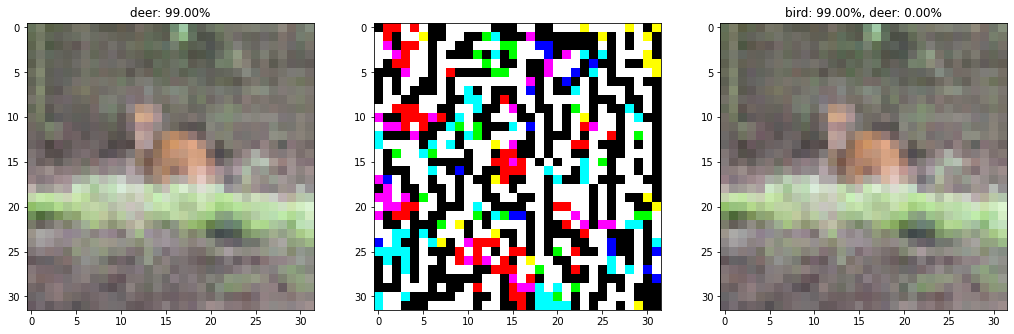

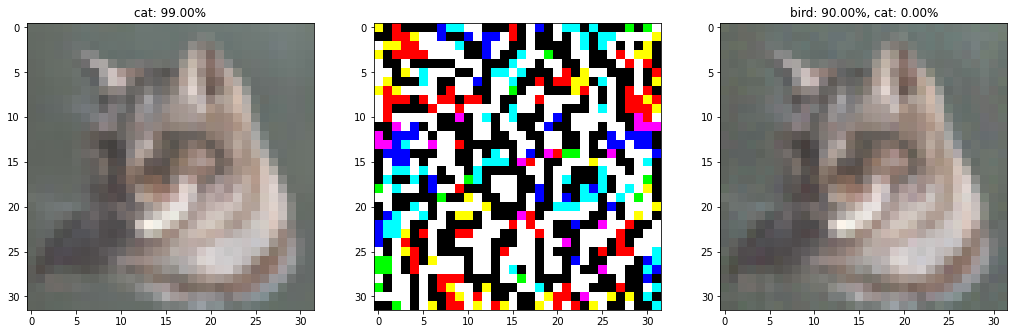

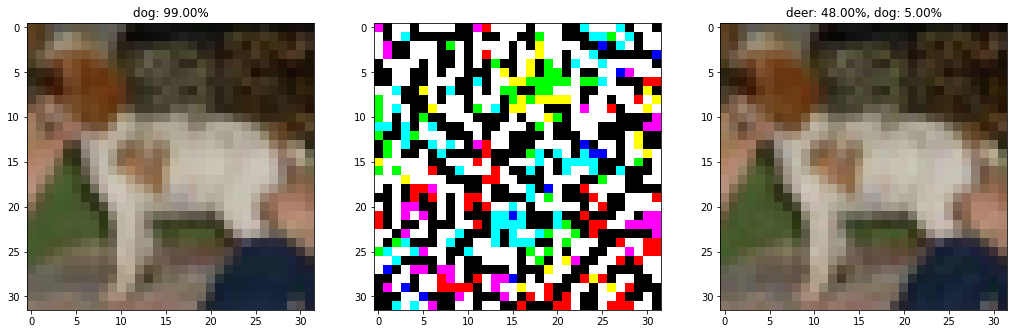

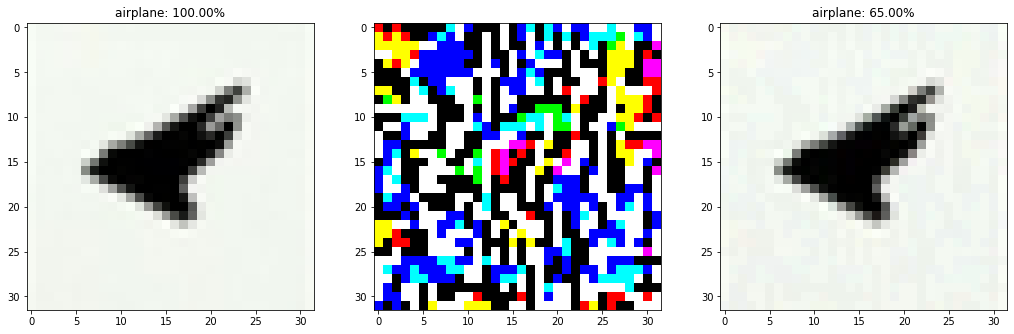

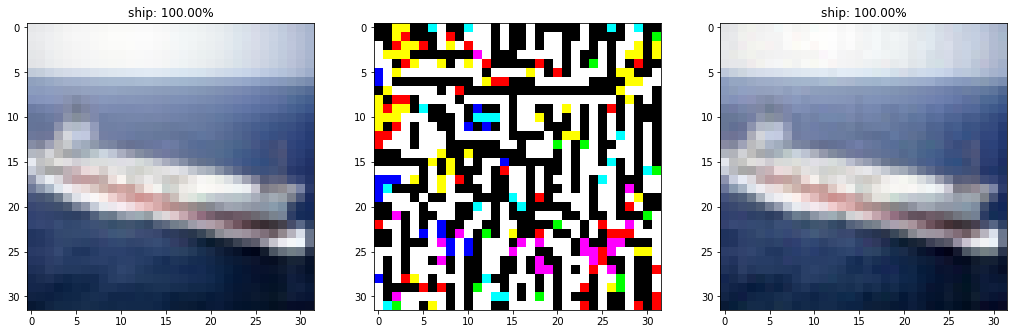

In [ ]:
sample_images = [32, 432, 12, 21, 54]


def get_preds_title(preds, initial_class_idx = None):
    pred_idx = preds[0].argmax()
    confidence = max(preds[0]).round(decimals=2) * 100

    title = '{}: {:.2f}%'.format(classes[pred_idx], confidence)

    if (initial_class_idx is not None and pred_idx != initial_class_idx):
        title += ', {}: {:.2f}%'.format(classes[initial_class_idx], preds[0][initial_class_idx].round(decimals=2) * 100)

    return title

def create_plot_adv_pattern(original_image, image_class_idx, model, eps = 0.01):
    plt.figure(figsize = (15, 10))

    original_preds = model.predict(original_image)

    label = tf.one_hot(image_class_idx, len(classes))
    label = tf.reshape(label, (1, len(classes)))
    perturbations = create_adversarial_pattern(original_image, label, model)
      
    perturbated_image = original_image + eps*perturbations
    perturbated_image = tf.clip_by_value(perturbated_image, 0, 1)
    perturbated_preds = model.predict(perturbated_image)

    plt.subplot(1, 3, 1)
    plt.imshow(original_image[0])
    plt.title(get_preds_title(original_preds))
    plt.subplot(1, 3, 2)
    plt.imshow(perturbations[0]*0.5+0.5)
    plt.subplot(1, 3, 3)
    plt.imshow(perturbated_image[0])
    plt.title(get_preds_title(perturbated_preds, image_class_idx))
    
    plt.tight_layout(pad = 4)

for idx in sample_images:
    create_plot_adv_pattern(test_images[:,idx], test_labels[idx].numpy().argmax(), model_vgg16)

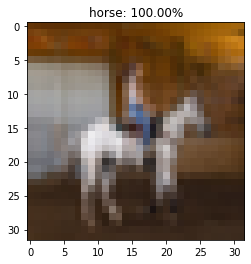

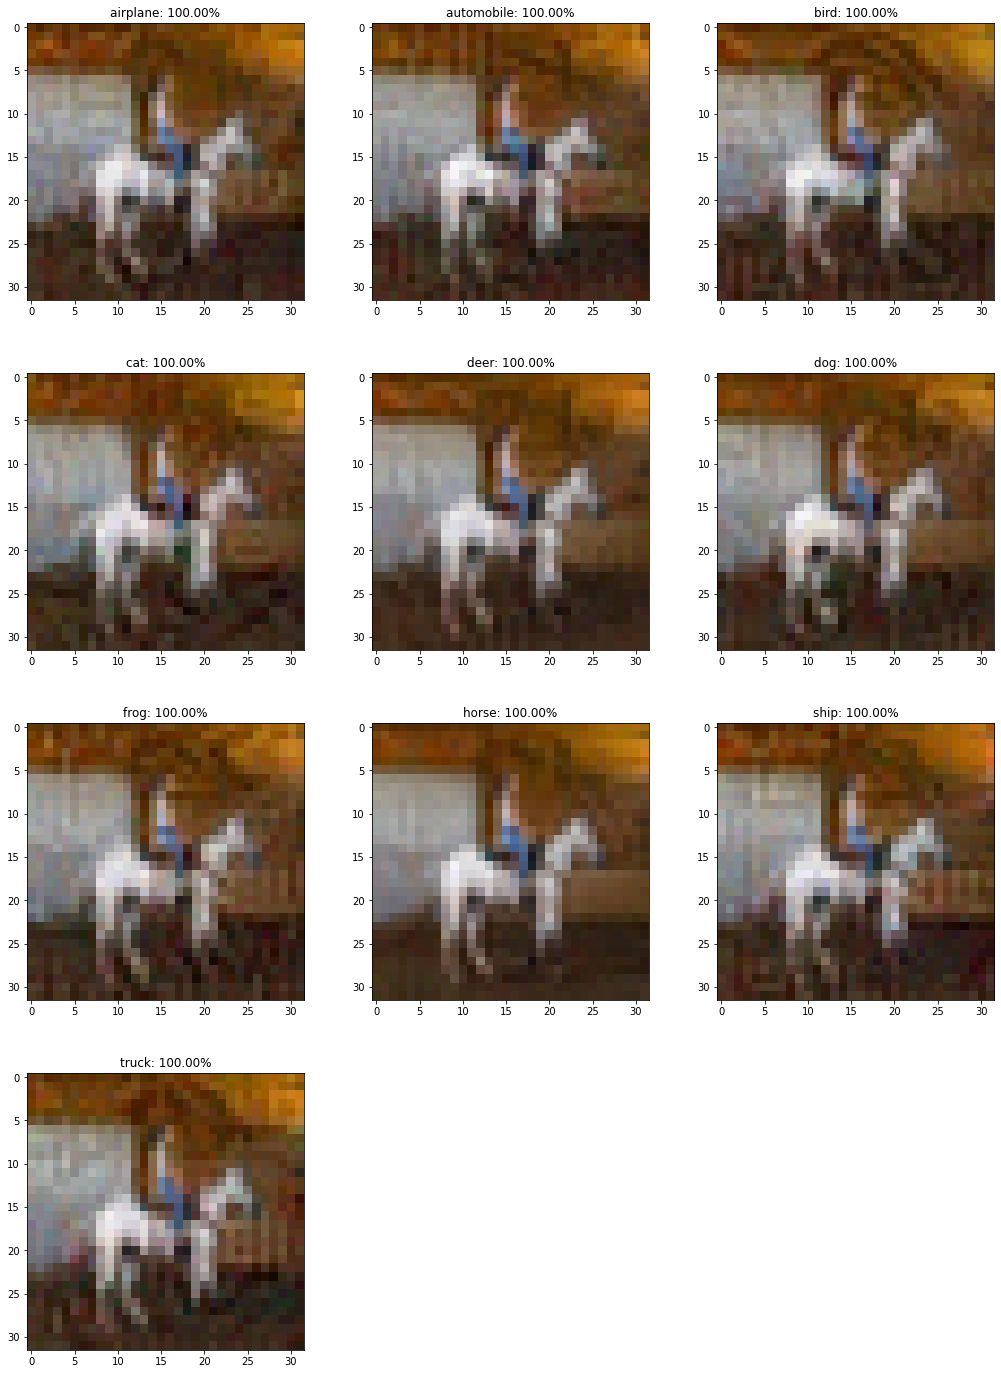

In [ ]:
def plot_adv_different_classes(original_image, image_class_idx, model, epsilon = 0.01, epochs = 20):
    plt.figure(figsize = (15, 20))

    for class_idx in range(len(classes)):
        adv_img = create_adversarial_image(model, original_image, image_class_idx, class_idx, epsilon, epochs)
        plt.subplot(4, 3, 1 + class_idx)
        plt.imshow(adv_img[0])
        preds = model.predict(adv_img)
        plt.title(get_preds_title(preds, class_idx))
          
    plt.tight_layout(pad = 4)

img_index = 7859

original_image = test_images[:,img_index]
plt.imshow(original_image[0])
original_preds = model_vgg16.predict(original_image)
plt.title(get_preds_title(original_preds))

plot_adv_different_classes(original_image, test_labels[img_index].numpy().argmax(), model_vgg16, epsilon=0.007)

## Działanie przykładów na różnych modelach

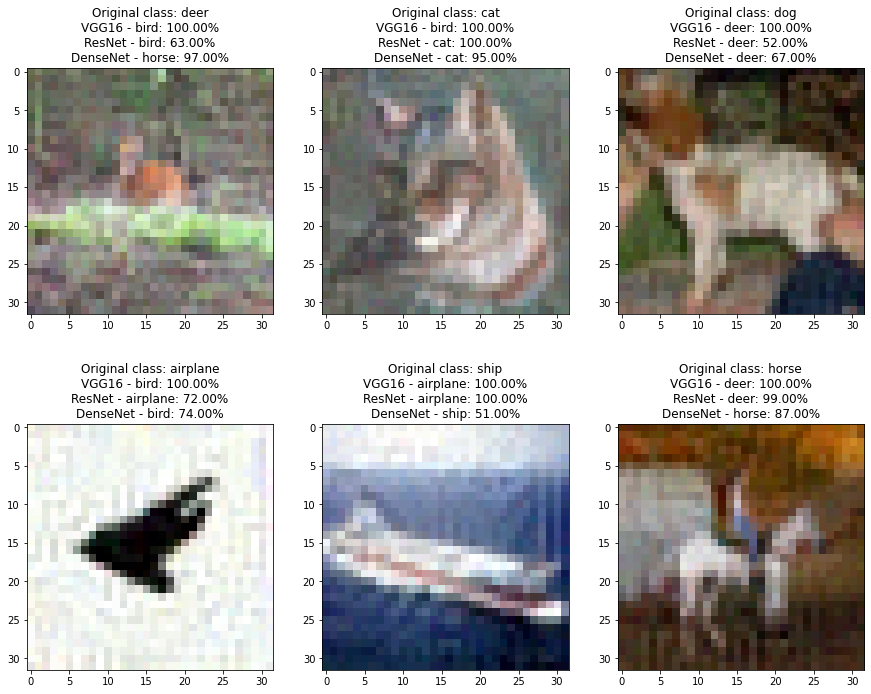

In [ ]:
import math

sample_images = [32, 432, 12, 21, 54, 7859]

plot_lines = math.ceil(len(sample_images) / 3.0)
plt.figure(figsize = (15, 6 * plot_lines))

for plot_idx, image_idx in enumerate(sample_images):
    original_image = test_images[:,image_idx]
    image_class_idx = test_labels[image_idx].numpy().argmax()
    adv_img = create_adversarial_image(model_vgg16, original_image, image_class_idx, epsilon = 0.01, epochs=10)
    plt.subplot(plot_lines, 3, 1 + plot_idx)
    plt.imshow(adv_img[0])

    preds_vgg16 = model_vgg16.predict(adv_img)
    preds_resnet = model_resnet.predict(adv_img)
    preds_densenet = model_densenet.predict(adv_img)

    plt.title("Original class: " + classes[image_class_idx] + '\nVGG16 - ' + get_preds_title(preds_vgg16) + '\nResNet - ' + get_preds_title(preds_resnet) + '\nDenseNet - ' + get_preds_title(preds_densenet))

#Zadanie 1:

Wybierz jedno zdjęcie z obrazów testowych, policz jego aktywacje dla 3 wybranych warstw konwolucyjnych (polecamy początkową, środkową i końcową) i zwizualizuj je z uzyciem funkcji visualize_activations dla modeli: VGG16, ResNet i DenseNet. Zwróć uwagę na róznice w wykrywaniu wzorców między modelami.

In [ ]:
from keras import models

#TODO: 
img_tensor = test_images[:, ?]
my_model = ?

In [ ]:
#Sprawdź jakie warstwy ma model i wybierz te indeksy, które cię interesują
my_model.summary()

In [ ]:
# TODO: wpisz indeksy wybranych warstw konwolucyjnych
layer_outputs = [model_vgg16.layers[?].output, 
                 model_vgg16.layers[?].output, 
                 model_vgg16.layers[?].output]
activations_model = models.Model(inputs=my_model.input, outputs=layer_outputs)

activations = activations_model.predict(img_tensor)
visualize_activations(activations_model, activations)

# Działanie przykładu adwersarialnego na zbiorze CIFAR10 i sieci VGG16.

W przykładzie dorysowujemy do obrazu jelenia ramkę 1 i 2 pikselową. 

Wybieramy przykład zdjecia z jeleniem i sprawdzamy predykcję na sieci VGG16.

In [ ]:
deer_tensor = test_images[:, 22]
plt.imshow(deer_tensor[0])
plt.show()

print('Predicted:', get_predicted_label(model_vgg16, deer_tensor), get_numeric_preds(model_vgg16, deer_tensor))

Przygotowujemy przykład adwersarialny: ustawiamy 2 brzegowe rzędy pikseli na niebieski kolor.

In [ ]:
tricky_dear = copy.deepcopy(deer_tensor)

tricky_dear[0, 0:2, :] =   [0, 0, 1]
tricky_dear[0, :, 0:2] =   [0, 0, 1]
tricky_dear[0, 30:32, :] =   [0, 0, 1]
tricky_dear[0, :, 30:32] =   [0, 0, 1]

plt.imshow(tricky_dear[0])
plt.show()

print('Predicted:', get_predicted_label(model_vgg16, tricky_dear), get_numeric_preds(model_vgg16, tricky_dear))

Udało się oszukać sieć - człowiek nadal widzi jelenia, jednak sieć widzi samolot. Sprawdzamy czy grubość ramki ma znaczenie i ponawiamy eksperyment z 1 piselem.

In [ ]:
tricky_dear2 = copy.deepcopy(deer_tensor)

tricky_dear2[0, 0:1, :] =   [0, 0, 1]
tricky_dear2[0, :, 0:1] =   [0, 0, 1]
tricky_dear2[0, 31:32, :] =   [0, 0, 1]
tricky_dear2[0, :, 31:32] =   [0, 0, 1]

plt.imshow(tricky_dear2[0])
plt.show()

print('Predicted:', get_predicted_label(model_vgg16, tricky_dear2), get_numeric_preds(model_vgg16, tricky_dear2))

Maksymalną wartość prawdopodobieństwa nadal otrzymał samolot, ale decyzja stała się już mniej pewna.

# Zadanie 2:

Zwizualizuj mapę ciepła wybranego samolotu ze zbioru danych (np. o indeksie 27 lub dowolnym innym) i zastanów się co mogło być powodem sukcesu powyższego przykładu adwersarialnego. Niektóre z rozpatrywanych modeli są głębokie i liczenie map ciepła dla całości zajęłoby dużo czasu. Głębsze wartwy nie dają interpretowalnej dla człowieka informacji, dlatego zaleca się wprowadzić parametr limitujący ilość warstw. Można też nałożyć wybraną mapę ciepła na obraz.

In [ ]:
def get_heatmaps(model, img_tensor, layer_names):
  cat_class_index = np.argmax(get_numeric_preds(model, img_tensor))

  heatmaps = []
  for layer_name in layer_names:
    # The is the output feature map of the given layer, in VGG16
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model([img_tensor])
      loss = predictions[:, cat_class_index]
    
    # This is the gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = tape.gradient(loss, conv_outputs)

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads_value = K.mean(grads, axis=(0, 1, 2))

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    conv_layer_output_value = conv_outputs.numpy()[0]
    pooled_grads_value = pooled_grads_value.numpy()

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(model.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmaps.append(np.mean(conv_layer_output_value, axis=-1))
  return heatmaps

def plot_heatmaps(heatmaps, layer_names):
  plt.figure(figsize=(18, 18))
  for i, hm in enumerate(heatmaps):
    plt.figure(figsize=(40,40))
    plt.subplot(5, 3, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

# nałożenie heatmap na oryginalny obraz:
def save_superimposed(hm, original_img, class_name, model_name, layer_name, show=True):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    # We resize the heatmap to have the same size as the original image
    img_hm = cv2.resize(img_heatmap, (original_img.shape[1], original_img.shape[0]))

    # We convert the heatmap to RGB
    img_hm = np.uint8(255 * img_hm)

    # We apply the heatmap to the original image
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.5 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.5 + original_img
    
    # Save the image to disk
    cv2.imwrite('./{}_{}_{}.jpg'.format(class_name, model_name,  layer_name.replace("/", '_')), superimposed_img)

    if show:
      plt.figure(figsize=(8, 8))
      plt.imshow(original_img)
      plt.title('input_image')

      plt.figure(figsize=(8, 8))
      img = image.img_to_array(
        image.load_img('./{}_{}_{}.jpg'.format(class_name, model_name, layer_name.replace("/", '_')))) / 255.
      plt.imshow(img)
      plt.title(layer_name)

In [ ]:
airplane_tensor = test_images[:, 27] 
airplane_img = (airplane_tensor[0]* 255.).astype(np.uint8)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

#TODO: wybierz model i nazwy warstw konwolucyjnych (zdefiniowane na początku) odpowiednie dla modelu
model = ?
layer_names = ?

heatmaps = get_heatmaps(model, airplane_tensor, layer_names)
plot_heatmaps(heatmaps, layer_names)

In [ ]:
#TODO: wybierz najlepiej interpretowalna warstwe
layer_idx = ?
layer_name = layer_names[layer_idx]
save_superimposed(heatmaps[layer_idx], airplane_img, 'airplane', 'model_name', layer_name, True)

# Zadanie 3: 
Przetestuj działanie dorysowanej ramki (jedno i dwupikselowej) do zdjęcia jelenia (22. zdjęcie w zbiorze) na modelach sieci ResNet i DenseNet. Porównaj działanie.

# Zadanie 4:

Użyj funkcji create_adversarial_pattern do generowania przykładów adwersarialnych, czyli mających na celu wymusić błędną klasyfikację sieci. Produkuje ona zakłócenia, mające formę kształtów charakterystycznych dla danej klasy.

a) Nałóż wygenerowane zakłócenia na oryginalny obraz w róznych stosunkach (1:99, 50:50 itp). Znajdź próg przy którym sieć VGG16 zostaje oszukana. 

In [ ]:
# TODO: wybierz model (z uprzednio wczytanych)
my_model = ???

# TODO: zrób predykcję używając wybranego modelu my_model i wybranego przykładu ze zbioru testowego
img_idx = ???
selected_img = test_images[:,img_idx]

image_probs = my_model.predict(selected_img)
image_confidence = max(get_numeric_preds(my_model, selected_img)).round(decimals=2)
image_class_index = test_labels[img_idx].numpy().argmax()
image_class = classes[image_class_index]

plt.figure()
plt.imshow( selected_img[0])
plt.title('{} : {:.2f}% Confidence'.format(image_class, image_confidence*100))
plt.show()

In [ ]:
# przygotuj argumenty wejściowe do funkcji tworzącej zakłócenie
label = tf.one_hot(image_class_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(selected_img, label, my_model)

# podglądnij jak wyglądają wygenerowane zakłócenia. 
# Czy mają coś wspólnego z heatmapą zdjęcia?
plt.imshow(perturbations[0]*0.5+0.5)
plt.show()

In [ ]:
#TODO: 1a)

b) Użyj funkcji create_adversarial_image, która produkuje zakłócenia, mające formę kształtów charakterystycznych dla danej klasy, a następnie nakłada je na zdjęcie. Proces ten powtarzany jest przez zadaną liczbę iteracji (epok) i im dłużej trwa z tym większą pewnością sieć wybiera błędną klasę.

Wybierz jeden obrazek ze zbioru i wygeneruj dla niego po jednym przykładzie adwersarialnym dla każdej klasy, zmuszając sieć VGG16 do błędnej klasyfikacji. Użyj progu mniejszego niż ten uzyskany w poprzednim zadaniu żeby zobaczyć jak zmienia się pewność klasyfikacji sieci w trakcie tworzenia coraz bardziej zaburzonego obrazu. Funkcja display_images pozwoli podglądnąć różnice między oryginalnym i zaburzonym zdjęciem.

In [ ]:
def display_images(model, adv_image, input_image):
  input_confidence = max(get_numeric_preds(model, input_image)).round(decimals=2)
  input_label = get_predicted_label(model, input_image)

  adv_confidence = max(get_numeric_preds(model, adv_image)).round(decimals=2)
  adv_label = get_predicted_label(model, adv_image)

  fig=plt.figure(figsize=(15, 30))
  fig.add_subplot(1, 3, 1)
  plt.imshow(input_image[0])
  plt.title('Before {} : {:.2f}% Confidence'.format(input_label, input_confidence*100))
  fig.add_subplot(1, 3, 2)
  plt.imshow(adv_image[0])
  plt.title('After {} : {:.2f}% Confidence'.format(adv_label, adv_confidence*100))
  fig.add_subplot(1, 3, 3)
  plt.imshow(1 - abs(adv_image[0] - input_image[0]))
  plt.title("Difference")
  plt.show()

In [ ]:
#TODO: 1b)
IMG_IDX = ?

#Zadanie 5:

a) Zrób ewaluację modelu VGG16 na zbiorze 100 pierwszych obrazów testowych. 

b) Użyj funkcj create_adversarial_image do zamiany serii tych 100 pierwszych zdjęć test_images na przykłady adwersarialne (ponad progiem oszukania sieci, który wyszedł z poprzedniego zadnia, użyj jednej epoki - na więcej nie mamy czasu). Następnie zrób ewaluację testowego zbioru adwersarialnego na dostarczonych sieciach, zanotuj skuteczność.

In [ ]:
#TODO:
LIMIT = 100

#Zadanie 6 (dodatkowe):

Wczytaj nowy model - jest to model sieci VGG16 nauczony na przykładach CIFAR10 oraz na przykładach adwersarialnych stworzonych dla tego zbioru. 

a) Sprawdź jaka jest skuteczność tego modelu na 100 zdjęciach z oryginalnego zbioru testowego test_images. Sprawdź jaka jest skuteczność tego modelu na zbiorze obrazów adwersarialnych przygotownych w poprzednim zadaniu. Porównaj ze skutecznościami otrzymanymi w poprzednim zadaniu.

b) Wygeneruj nowe 100 przykładów adwersarialnych stworzonych tym razem nie z użyciem VGG16 lecz ResNet lub DenseNet - do wyboru. Sprawdź skuteczność modelu VGG16 i VGG16_adversarial na tym zbiorze.

c) Sprawdź jak wyglądają heatmapy dowolnego obrazu (może to być zdjęcie z zadania 2) dla modelu VGG16 i VGG16_adversarial. Zwróć uwagę na różnice.

In [ ]:
!gdown --id 16h92VXFNIvEHxZQGhMSLzA9dIXHwv5Jp
!gdown --id 1m33seRAUBFrHVm1wFo16St7dGrEU4ZqH

model_vgg16_adversarial = load_model(os.path.join(BASE_PATH, 'vggAdversarial.h5'))
model_vgg16_adversarial.set_weights(np.load(os.path.join(BASE_PATH, 'vggAdversarial.npy')))

Gdy skończyłeś zadania i chcesz dowiedzieć się więcej:

https://www.youtube.com/watch?v=CIfsB_EYsVI